# Face Alignment

### Hourglass module

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
# для обучения
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [3]:
class Hourglass(nn.Module):
  def __init__(self, channels):
    super().__init__()
    #encoder
    self.enc1 = ResidualBlock(channels, channels)
    self.pool1 = nn.MaxPool2d(2, 2) # пока что возьмем необучаемые пулинги
    self.enc2 = ResidualBlock(channels, channels)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.enc3 = ResidualBlock(channels, channels)
    # убрали pool3, чтобы уменьшить размер только в 4 раза (256 -> 128 -> 64)
    self.enc4 = ResidualBlock(channels, channels)
    #decoder
    self.de1 = ResidualBlock(channels, channels)
    self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.de2 = ResidualBlock(channels, channels)
    self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.de3 = ResidualBlock(channels, channels)
    self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.de4 = ResidualBlock(channels, channels)

  def forward(self ,x):
    e1 = self.enc1(x)
    e2 = self.enc2(self.pool1(e1))
    e3 = self.enc3(self.pool2(e2))
    e4 = self.enc4(e3)

    # у меня возникли проблемы с размерностями, поэтому применим interolate
    d1 = self.de1(self.upsample1(e4))
    d1 = F.interpolate(d1, size=e3.shape[2:], mode='bilinear', align_corners=False) + e3
    d2 = self.de2(self.upsample2(d1))
    d2 = F.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=False) + e2
    d3 = self.de3(self.upsample3(d2))
    d3 = F.interpolate(d3, size=e1.shape[2:], mode='bilinear', align_corners=False) + e1
    d4 = self.de4(d3)
    return d4

### Stacked Hourglass Network

In [4]:
class StackedHN (nn.Module):
  def __init__(self, in_channels=3, out_channels=5):

    super().__init__()
    self.init_conv = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        ResidualBlock(64, 128),
        nn.MaxPool2d(2, 2),
        ResidualBlock(128, 128),
        ResidualBlock(128, 256)
    )
    # Выбор пал на два слоя Hourglass, тк при трех сетка становится слишком тяжелой и требует много VRAM
    self.hg1 = Hourglass(256)
    self.hg2 = Hourglass(256)

    self.out_conv1 = nn.Conv2d(256, out_channels, kernel_size=1)
    self.out_conv2 = nn.Conv2d(256, out_channels, kernel_size=1)

    self.merge1 = nn.Sequential(
        nn.Conv2d(out_channels, 256, kernel_size=1),
        ResidualBlock(256, 256) # с ним работает лучше
    )


  def forward(self, x):

    x = self.init_conv(x)

    #first
    hg1_out = self.hg1(x)
    out1 = self.out_conv1(hg1_out)
    #second
    merged2 = self.merge1(out1) + hg1_out
    hg2_out = self.hg2(merged2)
    out2 = self.out_conv2(hg2_out)

    return out1, out2

## Датасет

In [5]:
def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2, output_heatmap_size=(64, 64)):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    # Появилась необходимость преобразовать heatmap, тк картинки приведены к 256 на 256
    # в отличии от оригинальных 178 на 218
    # Хитмапы преобразуем к 64 на 64, чтобы соответствовать выводу модели
    heatmaps = []

    orig_h, orig_w = image_shape
    new_h, new_w = 256, 256

    for x, y in landmarks:
      scaled_x = x * (output_heatmap_size[1]/178) # скейл сначала на новый формат изо, затем на размер хитмапа x * 256/178 * 32/256
      scaled_y = y * (output_heatmap_size[0]/218) # аналогично с x

      hm = create_heatmap(output_heatmap_size, (scaled_x, scaled_y), sigma=sigma)
      heatmaps.append(hm)

    return np.array(heatmaps)

In [6]:
file_path = 'D:\\dlsPart2\\list_landmarks_align_celeba.txt'

# Загрузка данных (формат CelebA: 1 строка — заголовок, 2 строка — описание колонок)
landmarks_df = pd.read_csv(file_path, delim_whitespace=True, header=1)
landmarks_df.head()

C:\Users\odron\AppData\Local\Temp\ipykernel_22836\1016918608.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  landmarks_df = pd.read_csv(file_path, delim_whitespace=True, header=1)


,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
000001.jpg,69,109,106,113,77,142,73,152,108,154
000002.jpg,69,110,107,112,81,135,70,151,108,153
000003.jpg,76,112,104,106,108,128,74,156,98,158
000004.jpg,72,113,108,108,101,138,71,155,101,151
000005.jpg,66,114,112,112,86,119,71,147,104,150


In [7]:
print(landmarks_df.columns.tolist())

['lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']


In [8]:
def load_image(image_id):
    img_path = f'D:\\dlsPart2\\img_align_celeba3\\{image_id}'
    img = cv2.imread(img_path)
    return img

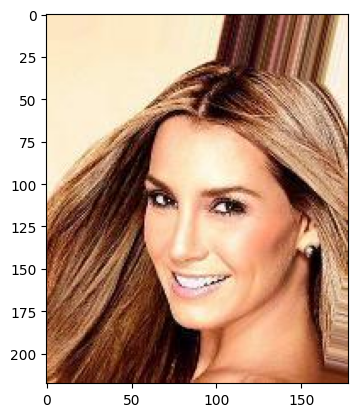

In [9]:
image = load_image('000001.jpg')
#bgr to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()

In [10]:
class CelebDataset:

  def __init__(self, df, sigma=2, output_heatmap_size=(64, 64), max_samples=None):

    self.sigma = sigma
    self.output_heatmap_size = output_heatmap_size
    self.img_folder = "D:\\dlsPart2\\img_align_celeba10000\\"
    existing_files = set(os.listdir(self.img_folder)) # Возьмем только то, что есть в обрезанном датасете
    self.df = df[df.index.isin(existing_files)]
    self.image_ids = self.df.index.tolist()

    if max_samples is not None and max_samples > 0:
      self.image_ids = self.image_ids[:max_samples]

    print(f"Загружено {len(self.image_ids)} существующих изображений")

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    image_path = os.path.join(self.img_folder, image_id)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)

    row = self.df.loc[image_id]
    landmarks = [
        (row['lefteye_x'], row['lefteye_y']),
        (row['righteye_x'], row['righteye_y']),
        (row['nose_x'], row['nose_y']),
        (row['leftmouth_x'], row['leftmouth_y']),
        (row['rightmouth_x'], row['rightmouth_y'])
    ]

    heatmaps = landmarks_to_heatmaps(
        image_shape=(218, 178),
        landmarks=landmarks,
        sigma=self.sigma,
        output_heatmap_size=self.output_heatmap_size
    )

    image = image.astype(np.float32) / 255.0
    heatmaps = heatmaps.astype(np.float32)

    image = torch.from_numpy(image).permute(2, 0, 1)  # [H, W, C] -> [C, H, W]
    heatmaps = torch.from_numpy(heatmaps)

    return image, heatmaps

In [11]:
# Создаём датасет
dataset = CelebDataset(df=landmarks_df, sigma=4, output_heatmap_size=(64, 64))

Загружено 10000 существующих изображений


image_id: 000381.jpg


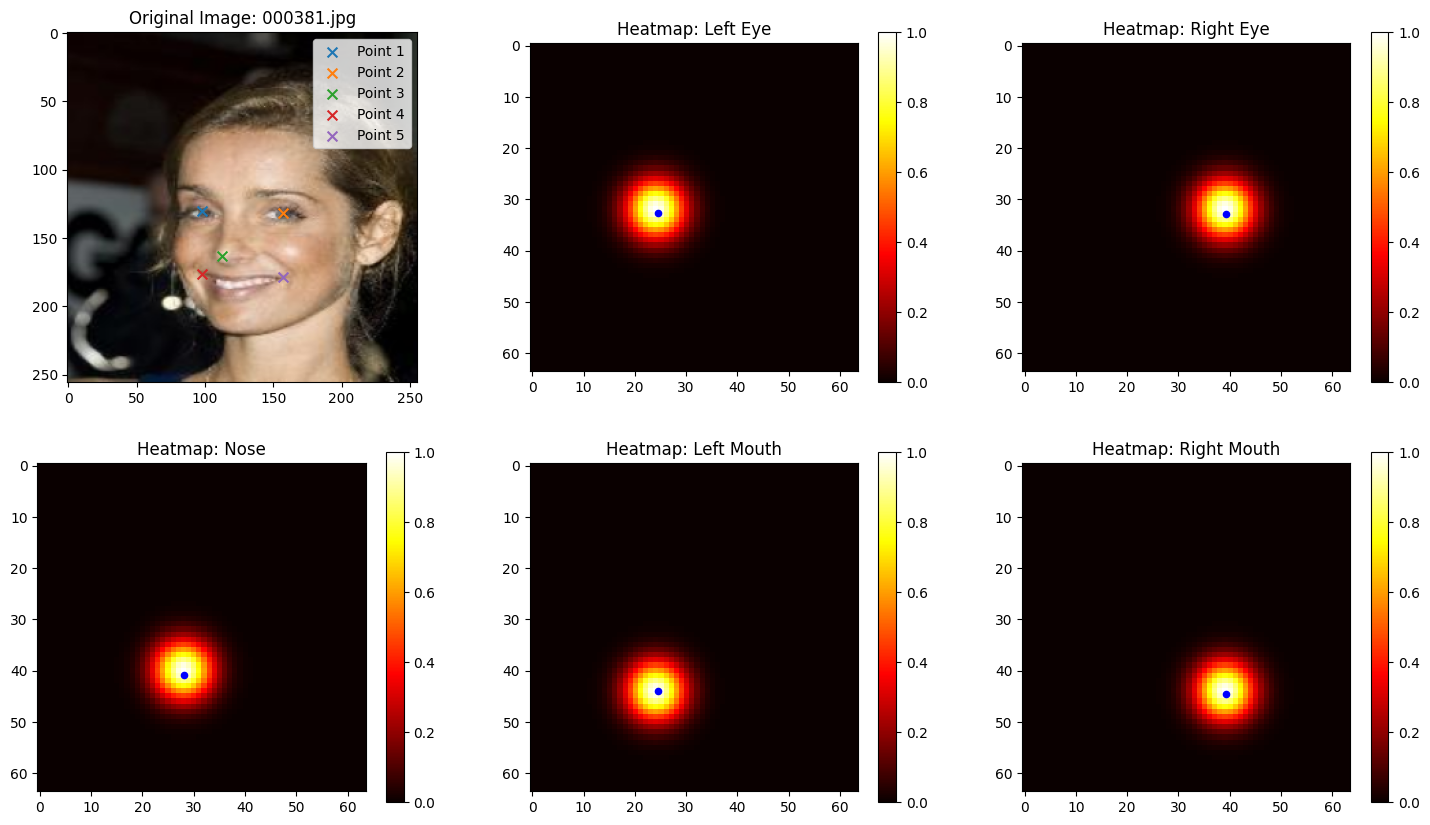

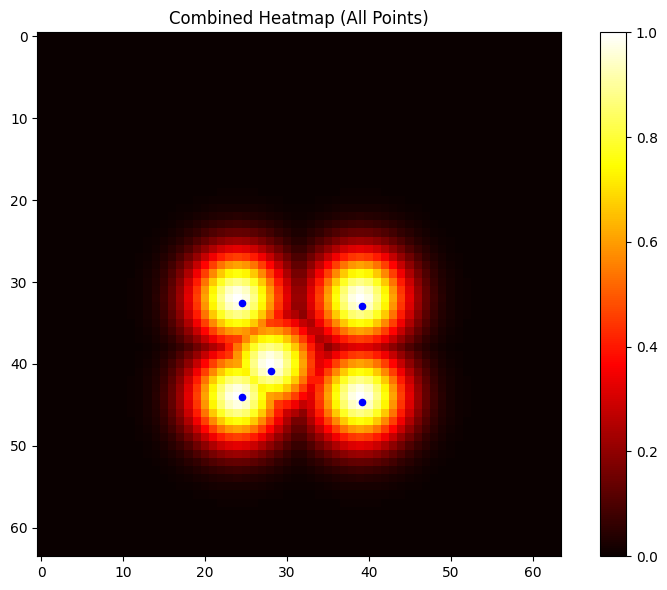


Информация о данных:
Имя файла: 000381.jpg
Размер изображения: torch.Size([3, 256, 256])
Размер heatmaps: torch.Size([5, 64, 64])
Значения пикселей изображения: [0.00, 1.00]
Значения heatmaps: [0.00, 1.00]
Sigma: 4


In [14]:
idx = 30 
try:
    image_id = dataset.image_ids[idx]
    print(f"image_id: {image_id}")
except IndexError:
    raise IndexError(f"Индекс {idx} выходит за пределы списка")

image, heatmaps = dataset[idx]

row = dataset.df.loc[image_id]
landmarks = [
    (row['lefteye_x'], row['lefteye_y']),
    (row['righteye_x'], row['righteye_y']),
    (row['nose_x'], row['nose_y']),
    (row['leftmouth_x'], row['leftmouth_y']),
    (row['rightmouth_x'], row['rightmouth_y'])
]

for x, y in landmarks:
    if not (0 <= x <= 178 and 0 <= y <= 218):
        print(f"Внимание: Координаты ({x}, {y}) выходят за границы изображения (178x218)")

# Масштабируем координаты landmarks для 256x256
orig_h, orig_w = 218, 178
new_h, new_w = 256, 256
image_landmarks = [(x * (new_w / orig_w), y * (new_h / orig_h)) for x, y in landmarks]

# Масштабируем координаты landmarks для heatmap 64x64
heatmap_size = (64, 64)
heatmap_landmarks = [(x * (heatmap_size[1] / orig_w), y * (heatmap_size[0] / orig_h)) for x, y in landmarks]

image_np = image.permute(1, 2, 0).numpy()  # [3, 256, 256] -> [256, 256, 3]

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_np)
for i, (x, y) in enumerate(image_landmarks):
    plt.scatter(x, y, s=50, marker='x', label=f'Point {i+1}')
plt.title(f"Original Image: {image_id}")
plt.legend()

point_names = ['Left Eye', 'Right Eye', 'Nose', 'Left Mouth', 'Right Mouth']
for i in range(5):
    plt.subplot(2, 3, i + 2)
    plt.imshow(heatmaps[i].cpu().numpy(), cmap='hot')  # Преобразуем тензор в NumPy
    plt.colorbar()
    plt.title(f"Heatmap: {point_names[i]}")
    x, y = heatmap_landmarks[i]
    plt.scatter(x, y, s=20, c='blue', marker='o')

plt.figure(figsize=(8, 6))
combined_heatmap = np.max(heatmaps.cpu().numpy(), axis=0)  
plt.imshow(combined_heatmap, cmap='hot')
plt.colorbar()
plt.title("Combined Heatmap (All Points)")

for x, y in heatmap_landmarks:
    plt.scatter(x, y, s=20, c='blue', marker='o')

plt.tight_layout()
plt.show()

print("\nИнформация о данных:")
print(f"Имя файла: {image_id}")
print(f"Размер изображения: {image.shape}")  # [3, 256, 256]
print(f"Размер heatmaps: {heatmaps.shape}")  # [5, 64, 64]
print(f"Значения пикселей изображения: [{image.min():.2f}, {image.max():.2f}]")
print(f"Значения heatmaps: [{heatmaps.min():.2f}, {heatmaps.max():.2f}]")
print(f"Sigma: {dataset.sigma}")

#Обучение

In [16]:
def visualize_predictions(model, dataset, device, epoch, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    point_names = ['Left Eye', 'Right Eye', 'Nose', 'Left Mouth', 'Right Mouth']

    # Визуализация изображений с точками
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        image, gt_heatmaps = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            _, pred_heatmaps = model(image_tensor)

        image = image.permute(1, 2, 0).cpu().numpy()
        gt_heatmaps = gt_heatmaps.cpu().numpy()
        pred_heatmaps = pred_heatmaps.squeeze(0).cpu().numpy()

        gt_points = [np.unravel_index(hm.argmax(), hm.shape) for hm in gt_heatmaps]
        pred_points = [np.unravel_index(hm.argmax(), hm.shape) for hm in pred_heatmaps]

        scale_x = 256 / 64  
        scale_y = 256 / 64 
        gt_points = [(y * scale_y, x * scale_x) for y, x in gt_points]
        pred_points = [(y * scale_y, x * scale_x) for y, x in pred_points]

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)

        # GT точки 
        for y, x in gt_points:
            plt.scatter(x, y, c='red', s=10, label='GT' if i == 0 else "")

        # Predicted точки
        for y, x in pred_points:
            plt.scatter(x, y, c='green', s=10, label='Pred' if i == 0 else "")

        plt.title(f"Sample {idx}")
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch} - Predictions (Red: GT, Green: Predicted)')
    plt.legend()
    plt.show()
    '''
    # Визуализация предсказанных heatmap'ов
    plt.figure(figsize=(18, 10))
    for i in range(5):
        plt.subplot(2, 3, i + 1)
        plt.imshow(pred_heatmaps[i], cmap='hot')
        plt.colorbar()
        plt.title(f"Predicted Heatmap: {point_names[i]}")
        x, y = pred_points[i]
        plt.scatter(x / scale_x, y / scale_y, s=20, c='blue', marker='o')  # Обратно масштабируем для heatmap
    plt.tight_layout()
    plt.show()
    '''

In [17]:
def train(model, train_dataset, val_dataset, epochs = 50 , batch_size = 32, lr = 0.001, device = 'cuda', savepath = "model.pth", pre_train =None):

  if pre_train is not None:
    model.load_state_dict(torch.load(pre_train))
    print(f"Загружены предобученные веса из {pre_train}")

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
  criterion = nn.MSELoss()
  model = model.to(device)
  history = {
      'train_loss': [],
      'val_loss': [],
      'best_val_loss': float('inf')
  }
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    for images, heatmaps in progress_bar:
      images = images.to(device)
      heatmaps = heatmaps.to(device)
      optimizer.zero_grad()
      out1, out2 = model(images)

      loss1 = criterion(out1, heatmaps)
      loss2 = criterion(out2, heatmaps)
      total_loss = loss1 + loss2

      total_loss.backward()
      optimizer.step()

      running_loss += total_loss.item() * images.size(0)
      progress_bar.set_postfix({
          'loss': total_loss.item(),
          'l1': loss1.item(),
          'l2': loss2.item(),
          'lr': optimizer.param_groups[0]['lr']  # Добавлено отображение LR
      })
    epoch_train_loss = running_loss / len(train_dataset)
    history['train_loss'].append(epoch_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for images, heatmaps in val_loader:
        images = images.to(device)
        heatmaps = heatmaps.to(device)
        _, out2 = model(images)
        val_loss += criterion(out2, heatmaps).item() * images.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    history['val_loss'].append(epoch_val_loss)

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < history['best_val_loss']:
      history['best_val_loss'] = epoch_val_loss
      torch.save(model.state_dict(), savepath)
      print(f"Модель сохранена с вал. лоссом: {epoch_val_loss:.4f}")

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Визуализация каждые 10 эпох
    if (epoch + 1) % 5 == 0 or epoch == 0:
      visualize_predictions(model, val_dataset, device, epoch+1)

  return model, history

In [ ]:
train_df, val_df = train_test_split(landmarks_df, test_size=0.2, random_state=42)

model = StackedHN(in_channels=3, out_channels=5)

dataset = CelebDataset(df=landmarks_df, sigma=4, output_heatmap_size=(64, 64))
train_dataset = CelebDataset(train_df, sigma=2, output_heatmap_size=(64, 64), max_samples=16000) # Можно руками регулировать, если не хочется весь датасет
val_dataset = CelebDataset(val_df, sigma=2, output_heatmap_size=(64, 64), max_samples=4000)

# отладка, если не работает
image, heatmaps = train_dataset[0]
print(f"Single image shape: {image.shape}")
print(f"Single heatmaps shape: {heatmaps.shape}")

Загружено 10000 существующих изображений
Загружено 7978 существующих изображений
Загружено 2022 существующих изображений
Single image shape: torch.Size([3, 256, 256])
Single heatmaps shape: torch.Size([5, 64, 64])


In [ ]:
trained_model, history = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=3,
    batch_size=32,
    lr=6.25e-6,
    device='cuda',
    savepath='best_hourglass.pth',
    pre_train = 'hend.pth',
)

# Видеопамяти требуется много (прмиерно 15 гб) эту часть обучал на коллабе

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

C:\Users\odron\AppData\Local\Temp\ipykernel_22836\759554398.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pre_train))


Загружены предобученные веса из hend.pth


Epoch 1/3:   0%|          | 0/250 [00:00<?, ?it/s]

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**.

In [12]:
def align_face(model, image_id, output_size=(256, 256)):

    image = load_image(image_id)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, output_size, interpolation=cv2.INTER_LINEAR)

    image_input = image_resized.astype(np.float32) / 255.0
    input_tensor = torch.from_numpy(image_input).permute(2, 0, 1).unsqueeze(0).float().to('cuda')

    with torch.no_grad():
        _, heatmaps = model(input_tensor)

    predicted_points = []
    heatmap_h, heatmap_w = heatmaps.shape[2], heatmaps.shape[3]

    for i in range(5): # хоть и точек надо 3, тк выравнивание только по ним, я вычислю пять,
                       # чтобы показать, как модель предсказывает точки.
        hm = heatmaps[0, i].cpu().numpy()
        y, x = np.unravel_index(hm.argmax(), hm.shape)

        x = x * (output_size[0] / heatmap_w)
        y = y * (output_size[1] / heatmap_h)
        predicted_points.append([x, y])

    predicted_points = np.array(predicted_points, dtype=np.float32)

    target_points = np.array([
        [70, 100],   # Левый глаз
        [186, 100],  # Правый глаз
        [128, 144],  # Нос
    ], dtype=np.float32)

    # Используем афинное преобразование, тк гомография работает очень нестабильно
    M, _ = cv2.estimateAffinePartial2D(predicted_points[0:3], target_points)

    # warpAffine ожидает матрицу M размером 2x3.
    # Добавляем borderMode, чтобы избежать черных областей по краям.
    aligned_image = cv2.warpAffine(image_resized, M, output_size, borderMode=cv2.BORDER_REPLICATE)

    '''

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_resized)
    plt.scatter(predicted_points[:, 0], predicted_points[:, 1], s=50, marker='x', color='red', label='Предсказанные точки')
    plt.title(f"Исходное изображение: {image_id}")
    plt.legend()
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(aligned_image)
    plt.title("Выравненное изображение")
    plt.axis('off')
    plt.show()
    '''
    return aligned_image


In [13]:
model = StackedHN(in_channels=3, out_channels=5).to('cuda')
state_dict = torch.load('hend.pth', map_location='cuda', weights_only=True)
model.load_state_dict(state_dict)
model.eval()

#aligned_img = align_face(model, image_id='000032.jpg')

StackedHN(
  (init_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ResidualBlock(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ResidualBlock(
      (skip): Identity()
      (conv1): Con

In [ ]:
def save_aligned_images(dataset, model, drive_path='D:\\dlsPart2\\Aligned_Images3\\', max_images=None):
    
    model.eval()
    os.makedirs(drive_path, exist_ok=True) # Создаём папку
    image_ids = dataset.image_ids[:max_images] if max_images is not None else dataset.image_ids

    for image_id in tqdm(image_ids, desc="Обработка изображений"):
        aligned_image = align_face(model, image_id, output_size=(256, 256))
        aligned_image_bgr = cv2.cvtColor(aligned_image, cv2.COLOR_RGB2BGR)
        output_filename = f"{image_id}"
        save_path = os.path.join(drive_path, output_filename)
        cv2.imwrite(save_path, aligned_image_bgr)

In [14]:
dataset = CelebDataset(df=landmarks_df, sigma=4, output_heatmap_size=(64, 64))

Загружено 10000 существующих изображений


In [17]:
save_aligned_images(
    dataset=dataset,
    model=model,
    drive_path='D:\\dlsPart2\\Aligned_Images10000\\',
    max_images=None
)

Обработка изображений: 100%|██████████| 10000/10000 [03:42<00:00, 44.90it/s]


# План заданий

По итогу, в этом блоке у вас следующие задачи:


*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Подготовить датасет, преобразовав точки в Heatmap'ы
*   Обучить модель
*   Найти или реализовать функцию, которая бы по предсказанным ключевым точкам делала бы выравнивание лица на картинке (face alignment)

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



**Удачи! У вас всё получится 💗!**